In [1]:
from eprTools import CW_spec
import matplotlib.pyplot as plt
import numpy as np
from time import time
from glob import glob

Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g
Param file not present or incorrectly named
Guessing centerfield = 3487g, sweepwidth 100g


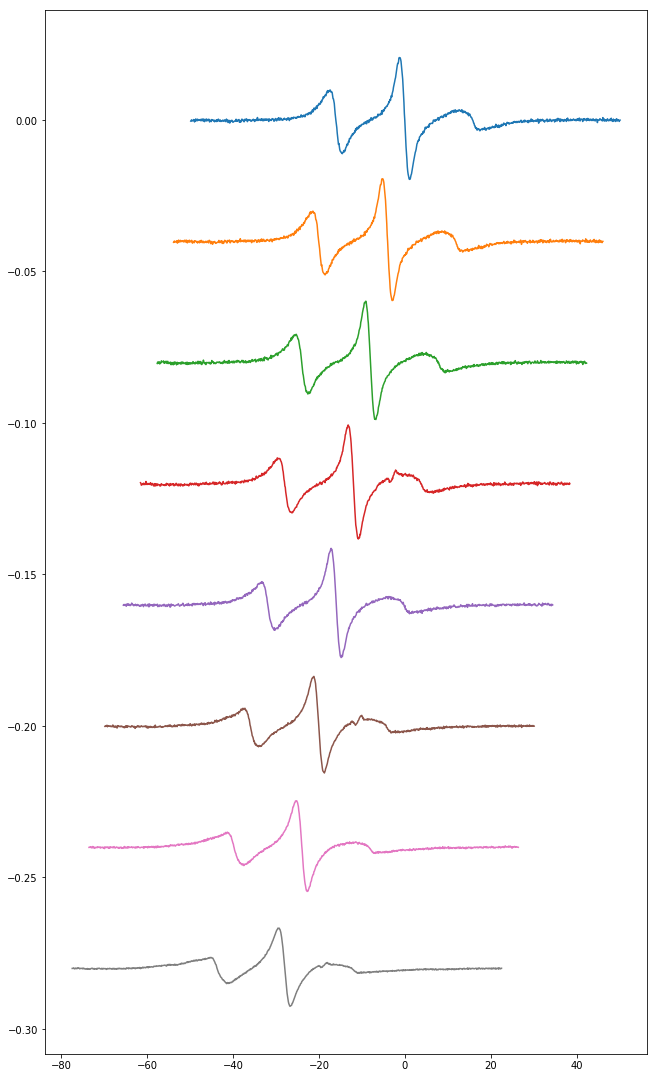

In [3]:
myfiles = glob('*.DTA')
fig1, ax1 = plt.subplots(figsize = (10.8, 19.2))


for i, file in enumerate(myfiles):
    
    Data = CW_spec.from_file(file, preprocess=True)
    Data.center()
    
    ax1.plot(Data.field - i * 4, Data.spec - i * 0.04)

plt.show()
    

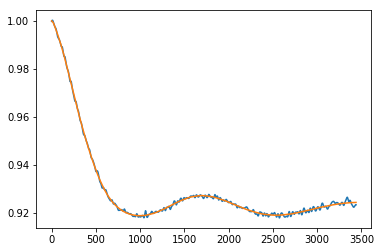

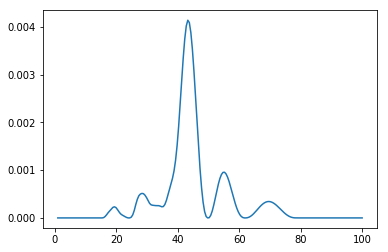

In [14]:
from scipy.optimize import nnls

def lsq_solve(A, b, alpha, AA, epsilon, free_set, binding_set):
    
    free_set.sort()
    free_set = free_set[::-1]

    binding_set.sort()
    binding_set = binding_set[::-1]

    B = A[:,free_set]
    BB = AA[free_set[:,None], free_set]
    
    if alpha > 0:
        B = B + alpha * np.identity(max(B.shape))[:B.shape[0], :B.shape[1]]
        BB = BB +  (alpha**2) * np.identity(max(BB.shape))[:BB.shape[0], :BB.shape[1]]

    
    dels = 0
    loops = 0
    lsq_loops = 0
    del_hist = []
    
    while True:
        loops += 1
        reduced_x = np.linalg.lstsq(B, b)
        reduced_x = reduced_x[0]
        
        deletion_set = []
        for i in np.arange(len(free_set)):
            if reduced_x[i] <= 0: 
                deletion_set.append(i)
        
        deletion_set = np.array(deletion_set)
        
        
        if len(deletion_set) == 0:
            break
        
        x_score = reduced_x[deletion_set]
        set_index = np.argsort(x_score)
        deletion_set = deletion_set[set_index]
        
        
        deletions_per_loop = AA.shape[1]
        if (len(deletion_set) > deletions_per_loop):
            deletion_set[deletions_per_loop+1:] = []
        
        
        deletion_set.sort()
        deletion_set = deletion_set[::-1]
        del_hist = np.union1d(del_hist, deletion_set)
        dels = dels + len(deletion_set)
        
        binding_set = np.concatenate([binding_set, free_set[deletion_set]])
        free_set = np.delete( free_set, deletion_set )
        
        B = A[:,free_set]
        BB = AA[free_set[:,None], free_set]
        
        if alpha > 0:
            B = B + alpha * np.identity(max(B.shape))[:B.shape[0], :B.shape[1]]
            BB = BB + (alpha**2) * np.identity(max(BB.shape))[:BB.shape[0], :BB.shape[1]]
    
    n = A.shape[1]
    
    x = np.zeros(n)
    x[free_set] = reduced_x
    
    residual = b - A.dot(x)
    score = np.sqrt(residual.dot(residual))
    
    return score, x, residual, free_set, binding_set, AA, epsilon, dels


def tntnn(A, b, alpha = 0, reltol = 0.001, AA = 0, use_AA = False, red_c = 0.2, exp_c = 1.2):
    
    if ( A.shape[0] != b.shape[0] ) :
        print('Length of b is not the same as A')
        return
    
    if ( len(b.shape) > 1) :
        print('b is not a vector')
        return
    
    
    if use_AA:
        if (AA == 0) or (AA.shape != (A.shape[1], A.shape[1])):
            AA = A.T.dot(A)
    
    epsilon = 10 * np.finfo(float).eps * np.linalg.norm(AA)
    AA = AA + epsilon * np.identity(AA.shape[1])
    
    free_set = np.arange(AA.shape[1])
    binding_set = []
    

    score, x, residual,free_set, binding_set, AA, epsilon, dels = lsq_solve(A, b, alpha, AA, epsilon, free_set, binding_set)    
    
    outer_loop = 0
    TotalInnerLoops = 0
    insertions = A.shape[1]
    
    while True:
        outer_loop += 1
        
        best_score = score
        best_x = x 
        best_free_set = free_set
        best_binding_set = binding_set
        best_insertions = insertions
        max_insertions = np.floor(exp_c * best_insertions)
        
        gradient = A.T.dot(residual)
        
        insertions = 0
        insertion_set = []
        
        for i in np.arange(len(binding_set)):
            if gradient[int(binding_set[i])] > 0:
                insertion_set.append(i)
                
        if insertions == 0:
            break
        
        grad_score = gradient[binding_set[insertion_set]]
        set_index =np.argsort(grad_score)[::-1]
        insertion_set = insertion_set[set_index]
        
        InnerLoop = 0
        while True:
            InnerLoop += 1
            TotalInnerLoops += 1
            
            insertions = np.floor(red_c * insertions)
            if insertions == 0:
                insertions = 1
            if insertions > max_insertions:
                insertions = max_insertions
                
            insertaion_set = insertion_set[:insertions]
            
            free_set = np.concatenate([free_set, binding_set[insertion_set]])
            binding_set = np.delete(binding_set, insertion_set)
            
            score, x, residual,free_set, binding_set, AA, epsilon, dels = lsq_solve(A, b, alpha, AA, epsilon, free_set, binding_set)
            
            if score < (best_score * (1 - rel_tol)):
                break
            
            score = best_score
            x = best_x
            free_set = best_free_set
            binding_set = best_binding_set
            max_insertions = floor(exp_c * best_insertions)
            
            if insertions == 1:
                break
    return x, AA, outer_loop, TotalInnerLoops

            
            
        
    
    